In [1]:
import cv2
import keras
import pandas as pd
from keras.utils.np_utils import to_categorical
from keras import layers
from keras.applications import EfficientNetV2B0
from keras.utils import Sequence
import numpy as np
from matplotlib import pyplot as plt
import math
from keras.preprocessing.image import ImageDataGenerator

In [2]:
data = pd.read_csv('../train_dataset_train/train.csv')

data_list = []
for i in data['ID_img']:
    image = cv2.imread('../train_dataset_train/train/'+i)
    image = cv2.resize(image, (224, 224))
    data_list.append(image)

In [3]:
def stratified_kfold(data,coef):
    test_index = []
    train_index = list(data.index)
    value_count = data['class'].value_counts()
    #print(value_count)
    for value in value_count.index:
        test_count = math.ceil(value_count[value]*coef)
        test_index += list(data[data['class'] == value].index[0:test_count])
    for index_test in test_index:
        train_index.remove(index_test)
    return train_index,test_index

x_train_full = np.array(data_list).astype('float32') / 255.0
y_train_full = data['class'].to_numpy().astype(int).reshape(-1, 1)
y_train_full = to_categorical(y_train_full)

train_index,test_index = stratified_kfold(data,0.1)
x_train, x_val = x_train_full[train_index], x_train_full[test_index]
y_train, y_val = y_train_full[train_index], y_train_full[test_index]

print(x_train.shape)
print(x_val.shape)


(4487, 224, 224, 3)
(503, 224, 224, 3)


In [4]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y
val_gen = DataGenerator(x_val, y_val, 12)
#train_gen = DataGenerator(x_train, y_train, 12)

datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range = 5,
    zoom_range = 0.05,
    channel_shift_range = 0.05,
    horizontal_flip=True)
train_gen = datagen.flow(x_train_full, y_train_full, 12)

In [5]:
num_classes = 8
img_size = 224

inputs = layers.Input(shape=(img_size, img_size, 3))
output = EfficientNetV2B0(include_top=True, weights='3_weights_EfficientNetb0v2_ep150_full.h5', classes=num_classes,include_preprocessing = False, input_shape = (224,224,3))(inputs)#,include_preprocessing = False
model = keras.Model(inputs,output)
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=["accuracy"])
model.summary()
his = model.fit(train_gen,epochs=1,validation_data = val_gen)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, 8)                5929560   
 al)                                                             
                                                                 
Total params: 5,929,560
Trainable params: 5,868,952
Non-trainable params: 60,608
_________________________________________________________________
416/416 [==============================] - 64s 118ms/step - loss: 0.0525 - accuracy: 0.9816 - val_loss: 0.0134 - val_accuracy: 0.9940


In [6]:
model.layers[1].save_weights('3_weights_EfficientNetb0v2_ep151_full.h5')

In [7]:
model.save('3_EfficientNetb0v2_ep151_full.h5')

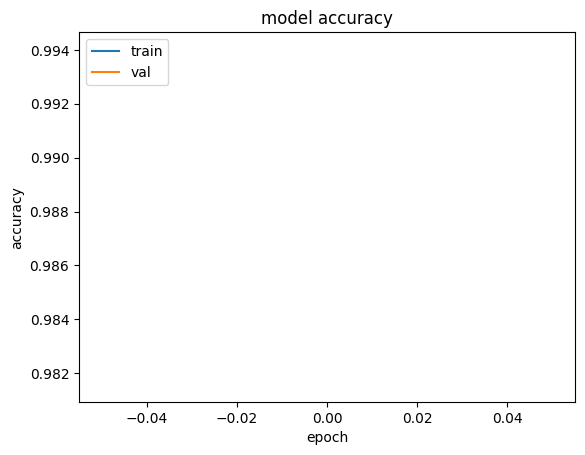

In [8]:
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()